In [2]:
# ============================== 📂 Dataset Structure Overview ==============================

# 🎯 Objective: Human Activity Recognition using 3-axis Accelerometer Data (TinyML Ready)

# 📁 CSV Files Used:
# ----------------------------------------------------------------------------------
# 1. accelerometer_3axis_train.csv   → Shape: (7352, 128, 3)
# 2. accelerometer_3axis_test.csv    → Shape: (2947, 128, 3)
# 3. y_train_labels.csv              → Shape: (7352, 6)   # One-hot encoded labels
# 4. y_test_labels.csv               → Shape: (2947, 6)   # One-hot encoded labels

# 🧠 Data Dimensions:
# ----------------------------------------------------------------------------------
# - Each sample = 128 time steps (over 2.56 seconds) of 3-axis accelerometer data
# - Shape per sample = (128, 3) → [X, Y, Z] acceleration readings
# - Final shape for training:   X_train → (6249, 128, 3),  y_train → (6249, 6)
# - Final shape for validation: X_val   → (1103, 128, 3),  y_val   → (1103, 6)
# - Final shape for testing:    X_test  → (2947, 128, 3),  y_test  → (2947, 6)

# 📌 Class Labels (6 total):
# ----------------------------------------------------------------------------------
# 0 → WALKING
# 1 → WALKING_UPSTAIRS
# 2 → WALKING_DOWNSTAIRS
# 3 → SITTING
# 4 → STANDING
# 5 → LAYING

# 📝 Notes:
# - The CSVs were generated from UCI HAR Dataset inertial signal files.
# - Values are normalized and suitable for training with 1D CNN models.
# - Data split: 85% train / 15% validation from original training set.

# ===========================================================================================

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Set CSV path
csv_dir = r"G:\Machine Learning\Human Activity Recognition ESP32\Dataset\refined_dataset_for_use"

# Load features and reshape
X = pd.read_csv(csv_dir + r"\accelerometer_3axis_time_series_train.csv").values
X = X.reshape(-1, 128, 3)

# Load and one-hot encode labels
y = pd.read_csv(csv_dir + r"\accelerometer_labels_y_train.csv")["label"].values
y = to_categorical(y, num_classes=6)

# Split train into 85% train / 15% validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)

# Load test set
X_test = pd.read_csv(csv_dir + r"\accelerometer_3axis_time_series_test.csv").values.reshape(-1, 128, 3)
y_test = pd.read_csv(csv_dir + r"\accelerometer_labels_y_test.csv")["label"].values
y_test = to_categorical(y_test, num_classes=6)

print("Shapes:")
print("Train:", X_train.shape, y_train.shape)
print("Val:  ", X_val.shape, y_val.shape)
print("Test: ", X_test.shape, y_test.shape)

Shapes:
Train: (6249, 128, 3) (6249, 6)
Val:   (1103, 128, 3) (1103, 6)
Test:  (2947, 128, 3) (2947, 6)


In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout

model = Sequential([
    Conv1D(16, 3, activation='relu', input_shape=(128, 3)),
    MaxPooling1D(2),
    Conv1D(32, 3, activation='relu'),
    MaxPooling1D(2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(6, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

c:\Users\User\.conda\envs\test\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_10 (Conv1D)              │ (None, 126, 16)        │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_10 (MaxPooling1D) │ (None, 63, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_11 (Conv1D)              │ (None, 61, 32)         │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_11 (MaxPooling1D) │ (None, 30, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 960)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │        61,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 63,622 (248.52 KB)

 Trainable params: 63,622 (248.52 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=250,
    batch_size=64,
    verbose=1
)

Epoch 1/250
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3298 - loss: 1.4699 - val_accuracy: 0.5494 - val_loss: 0.8980
Epoch 2/250
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5169 - loss: 0.9173 - val_accuracy: 0.6002 - val_loss: 0.7683
Epoch 3/250
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5891 - loss: 0.7863 - val_accuracy: 0.6337 - val_loss: 0.7195
Epoch 4/250
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6168 - loss: 0.7307 - val_accuracy: 0.6664 - val_loss: 0.6892
Epoch 5/250
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6422 - loss: 0.6928 - val_accuracy: 0.6673 - val_loss: 0.6587
Epoch 6/250
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6576 - loss: 0.6743 - val_accuracy: 0.7643 - val_loss: 0.6404
Epoch 7/250
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6978 - loss: 0.6242 - val_accuracy: 0.7498 - val_loss: 0.6052
Epoch 8/250
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7085 - loss: 0.5935 - val_accuracy: 0.7770 - v

Final Validation Accuracy: 0.8531


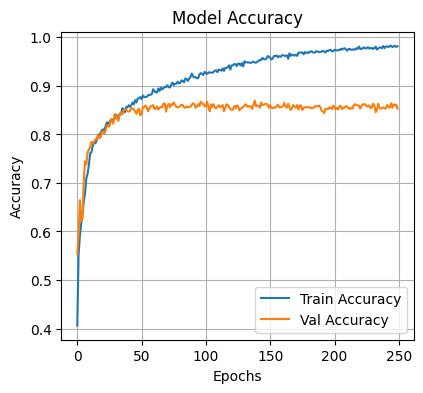

In [20]:
import matplotlib.pyplot as plt

# Plot Accuracy
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()
plt.grid(True)


# Get final validation accuracy
final_val_acc = history.history['val_accuracy'][-1]
print(f"Final Validation Accuracy: {final_val_acc:.4f}")

In [22]:
loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Final Test Accuracy: {test_accuracy:.4f}")

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8334 - loss: 1.3405
Final Test Accuracy: 0.8446


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


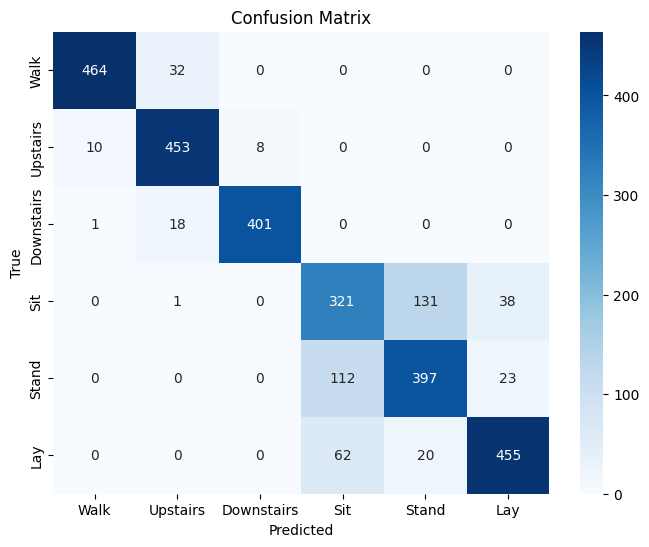

📊 Classification Report:
              precision    recall  f1-score   support

        Walk       0.98      0.94      0.96       496
    Upstairs       0.90      0.96      0.93       471
  Downstairs       0.98      0.95      0.97       420
         Sit       0.65      0.65      0.65       491
       Stand       0.72      0.75      0.74       532
         Lay       0.88      0.85      0.86       537

    accuracy                           0.85      2947
   macro avg       0.85      0.85      0.85      2947
weighted avg       0.85      0.85      0.85      2947

✅ Accuracy:    0.8453
🎯 Macro F1:    0.8505
🎯 Micro F1:    0.8453


In [26]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# === Step 1: Predict test labels ===
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# === Step 2: Confusion Matrix ===
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Walk", "Upstairs", "Downstairs", "Sit", "Stand", "Lay"],
            yticklabels=["Walk", "Upstairs", "Downstairs", "Sit", "Stand", "Lay"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# === Step 3: Classification Report ===
print("📊 Classification Report:")
print(classification_report(y_true, y_pred, target_names=[
    "Walk", "Upstairs", "Downstairs", "Sit", "Stand", "Lay"
]))

# === Step 4: Overall Scores ===
acc = accuracy_score(y_true, y_pred)
macro_f1 = f1_score(y_true, y_pred, average='macro')
micro_f1 = f1_score(y_true, y_pred, average='micro')

print(f"✅ Accuracy:    {acc:.4f}")
print(f"🎯 Macro F1:    {macro_f1:.4f}")
print(f"🎯 Micro F1:    {micro_f1:.4f}")

In [27]:
import os
import tensorflow as tf
import numpy as np

# === Set your desired directories ===
keras_dir = r"G:\Machine Learning\Human Activity Recognition ESP32\Dataset\Models\Tensorflow"
tflite_dir = r"G:\Machine Learning\Human Activity Recognition ESP32\Dataset\Models\tfLite"
opt_tflite_dir = r"G:\Machine Learning\Human Activity Recognition ESP32\Dataset\Models\optimized(quantized)_tfLite"



# === 1. Save the TensorFlow (Keras) model (.h5) ===
keras_model_path = os.path.join(keras_dir, "gesture_model.h5")
model.save(keras_model_path)
print(f"✅ Keras model saved to: {keras_model_path}")

# === 2. Save standard TFLite model ===
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

tflite_model_path = os.path.join(tflite_dir, "gesture_model.tflite")
with open(tflite_model_path, "wb") as f:
    f.write(tflite_model)
print(f"✅ TFLite model saved to: {tflite_model_path}")

# === 3. Save optimized (quantized) TFLite model ===
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_optimized_model = converter.convert()

opt_model_path = os.path.join(opt_tflite_dir, "gesture_model_optimized.tflite")
with open(opt_model_path, "wb") as f:
    f.write(tflite_optimized_model)
print(f"✅ Optimized TFLite model saved to: {opt_model_path}")

✅ Keras model saved to: G:\Machine Learning\Human Activity Recognition ESP32\Dataset\Models\Tensorflow\gesture_model.h5
INFO:tensorflow:Assets written to: C:\Users\User\AppData\Local\Temp\tmpzsdmwn9e\assets


INFO:tensorflow:Assets written to: C:\Users\User\AppData\Local\Temp\tmpzsdmwn9e\assets


Saved artifact at 'C:\Users\User\AppData\Local\Temp\tmpzsdmwn9e'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 3), dtype=tf.float32, name='keras_tensor_45')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  2379414051856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2379414055120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2379414054928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2379414055312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2379414056272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2379414053584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2379414052624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2379414053968: TensorSpec(shape=(), dtype=tf.resource, name=None)
✅ TFLite model saved to: G:\Machine Learning\Human Activity Recognition ESP32\Dataset\Models\tfLite\gesture_model.tflite
INFO:tensorflow:Assets wr

INFO:tensorflow:Assets written to: C:\Users\User\AppData\Local\Temp\tmp_y98yn1z\assets


Saved artifact at 'C:\Users\User\AppData\Local\Temp\tmp_y98yn1z'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 3), dtype=tf.float32, name='keras_tensor_45')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  2379414051856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2379414055120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2379414054928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2379414055312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2379414056272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2379414053584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2379414052624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2379414053968: TensorSpec(shape=(), dtype=tf.resource, name=None)
✅ Optimized TFLite model saved to: G:\Machine Learning\Human Activity Recognition ESP32\Dataset\Models\optimized(quantized)_tfLite\gesture_model_o

In [28]:
import tensorflow as tf
import numpy as np
import os
import time
from sklearn.metrics import accuracy_score

# === Paths from your setup ===
keras_model_path = r"G:\Machine Learning\Human Activity Recognition ESP32\Dataset\Models\Tensorflow\gesture_model.h5"
tflite_model_path = r"G:\Machine Learning\Human Activity Recognition ESP32\Dataset\Models\tfLite\gesture_model.tflite"
opt_tflite_model_path = r"G:\Machine Learning\Human Activity Recognition ESP32\Dataset\Models\optimized(quantized)_tfLite\gesture_model_optimized.tflite"

# === Assume X_test, y_test already loaded and preprocessed ===
# y_test should be one-hot encoded, X_test shape: (n_samples, 128, 3)

# === 1. Evaluate Keras model ===
keras_model = tf.keras.models.load_model(keras_model_path)
y_pred_keras = keras_model.predict(X_test)
y_pred_keras_cls = np.argmax(y_pred_keras, axis=1)
y_true_cls = np.argmax(y_test, axis=1)
keras_acc = accuracy_score(y_true_cls, y_pred_keras_cls)
print(f"📦 Keras (.h5) Accuracy: {keras_acc:.4f}")

# === 2. Function to evaluate TFLite models ===
def evaluate_tflite_model(model_path, X_data):
    interpreter = tf.lite.Interpreter(model_path=model_path)
    interpreter.allocate_tensors()
    
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    preds = []
    total_time = 0

    for sample in X_data:
        sample = sample[np.newaxis, :, :].astype(np.float32)
        interpreter.set_tensor(input_details[0]['index'], sample)

        start = time.time()
        interpreter.invoke()
        end = time.time()

        total_time += (end - start)

        output = interpreter.get_tensor(output_details[0]['index'])
        preds.append(np.argmax(output))

    avg_time_ms = (total_time / len(X_data)) * 1000
    return np.array(preds), avg_time_ms

# === 3. Evaluate Standard TFLite Model ===
tflite_preds, tflite_time = evaluate_tflite_model(tflite_model_path, X_test)
tflite_acc = accuracy_score(y_true_cls, tflite_preds)
print(f"💡 TFLite Accuracy:         {tflite_acc:.4f} | Avg Inference: {tflite_time:.2f} ms/sample")

# === 4. Evaluate Optimized (Quantized) TFLite Model ===
opt_preds, opt_time = evaluate_tflite_model(opt_tflite_model_path, X_test)
opt_acc = accuracy_score(y_true_cls, opt_preds)
print(f"⚡ Optimized TFLite Accuracy: {opt_acc:.4f} | Avg Inference: {opt_time:.2f} ms/sample")

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
📦 Keras (.h5) Accuracy: 0.8453
💡 TFLite Accuracy:         0.8453 | Avg Inference: 0.01 ms/sample
⚡ Optimized TFLite Accuracy: 0.8412 | Avg Inference: 0.01 ms/sample


c:\Users\User\.conda\envs\test\Lib\site-packages\tensorflow\lite\python\interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)
c:\Users\User\.conda\envs\test\Lib\site-packages\tensorflow\lite\python\interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


In [29]:
# ============================== ✅ Evaluation Checklist ==============================
# ✅ GOOD SIGNS TO LOOK FOR AFTER TESTING MODELS

# 1. High Keras Accuracy (e.g., ~84–85%)
#    → Indicates the model is well-trained on the dataset.

# 2. TFLite Accuracy is nearly equal to Keras Accuracy (difference ≤ 0.5%)
#    → Confirms that TFLite conversion preserved the model performance.

# 3. Optimized (quantized) TFLite model has ≤ 1–2% drop in accuracy
#    → Acceptable and expected due to 8-bit quantization. A small trade-off for speed and size.

# 4. Inference Time Order:
#    Optimized TFLite < Standard TFLite < Keras
#    → Faster inference indicates proper optimization for edge devices.

# 5. Consistent Predictions Across All Models
#    → Class labels predicted should be mostly the same across formats.

# =====================================================================================

In [30]:
import os

# === Model paths from your project ===
keras_model_path = r"G:\Machine Learning\Human Activity Recognition ESP32\Dataset\Models\Tensorflow\gesture_model.h5"
tflite_model_path = r"G:\Machine Learning\Human Activity Recognition ESP32\Dataset\Models\tfLite\gesture_model.tflite"
opt_model_path   = r"G:\Machine Learning\Human Activity Recognition ESP32\Dataset\Models\optimized(quantized)_tfLite\gesture_model_optimized.tflite"

# === Function to get size in KB and MB
def get_file_size(path):
    size_bytes = os.path.getsize(path)
    size_kb = size_bytes / 1024
    size_mb = size_kb / 1024
    return size_kb, size_mb

# === Print sizes
for name, path in [
    ("Keras (.h5)", keras_model_path),
    ("TFLite (.tflite)", tflite_model_path),
    ("Optimized TFLite", opt_model_path)
]:
    kb, mb = get_file_size(path)
    print(f"{name} → {kb:.2f} KB ({mb:.2f} MB)")

Keras (.h5) → 786.56 KB (0.77 MB)
TFLite (.tflite) → 253.66 KB (0.25 MB)
Optimized TFLite → 70.37 KB (0.07 MB)


In [31]:
# ============================== 📦 TinyML Model Size Guidelines ==============================

# ✅ TARGET DEVICE MEMORY BUDGETS
# -----------------------------------------------------------------------------
# | Device Type              | Flash (ROM)  | RAM        | Ideal Model Size |
# |--------------------------|--------------|------------|------------------|
# | Microcontrollers (MCUs)  | 256 KB–1 MB  | 32–256 KB  | < 250 KB         |
# | Arduino Nano 33 BLE Sense| 1 MB         | 256 KB     | ≤ 250 KB         |
# | ESP32 (typical variant)  | 4 MB         | 520 KB     | ≤ 500 KB         |
# | Smartphones / RaspberryPi| 1 GB+        | N/A        | No strict limit  |
# -----------------------------------------------------------------------------

# ✅ BEST PRACTICE FOR TinyML DEPLOYMENT:
# → gesture_model_optimized.tflite should be under ~250 KB
# → Best if fully quantized (int8) to reduce size & RAM usage

# ✅ SIZE OPTIMIZATION TIPS:
# 1. Apply full integer quantization (int8 or uint8)
# 2. Use lightweight architectures (1D CNNs, fewer layers)
# 3. Replace Flatten + Dense with GlobalAveragePooling1D
# 4. Avoid complex RNNs, large embeddings, or unsupported ops

# ✅ EXAMPLE MODEL SIZES:
# - Simple 1D CNN (float32):           ~900 KB
# - Quantized 1D CNN (int8):           ~100–250 KB
# - Quantized LSTM or GRU:             ~200–400 KB
# - MobileNetV1 (Tiny, quantized):     ~200–300 KB

# =============================================================================================

In [ ]:
import os

# Define the path to the TFLite model
tflite_model_path = r"G:\Machine Learning\Human Activity Recognition ESP32\Dataset\Models\optimized(quantized)_tfLite\gesture_model_optimized.tflite"

# Define the directory where you want to save the header file
output_directory = r"G:\Machine Learning\Human Activity Recognition ESP32\Dataset\Models\C-File"

# Ensure the output directory exists (create it if necessary)
os.makedirs(output_directory, exist_ok=True)

# Function to convert the binary model to a C array
def hex_to_c_array(model_data, array_name):
    hex_data = model_data.hex()
    c_array = f"const unsigned char {array_name}[] = {{\n"
    # Break hex data into chunks of 16 bytes (32 characters)
    for i in range(0, len(hex_data), 32):
        c_array += " 0x" + ", 0x".join(hex_data[i:i+32][j:j+2] for j in range(0, len(hex_data[i:i+32]), 2)) + ",\n"
    c_array += "};\n"
    return c_array

# Read the TFLite model file as binary data
with open(tflite_model_path, 'rb') as file:
    tflite_model = file.read()

# Define the C header file name
c_model_name = "gesture_model_optimized_c"

# Define the full path where the header file will be saved
header_file_path = os.path.join(output_directory, c_model_name + '.h')

# Write the model data to the C header file
with open(header_file_path, 'w') as file:
    file.write(hex_to_c_array(tflite_model, c_model_name))

print(f"✅ The model has been written to {header_file_path}")